In [30]:
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt 
import numpy as np 
import torch.optim as optim 
from tqdm import tqdm

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Prepare MNIST Data for Training

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
# Define the preprocessing transformation
class BinaryTransform:
    def __call__(self, x):
        # Convert the image to a numpy array, normalize to [0, 1], and apply the threshold
        x = np.array(x) / 255.0  # Normalize pixel values to [0, 1]
        x = (x >= 0.4).astype(np.float32)  # Apply threshold to convert to binary (0s and 1s)
        x = torch.from_numpy(x)  # Convert back to PyTorch tensor
        return x.unsqueeze(0)  # for channel dimension ( 1, 28, 28)

# Create the transform with binary conversion
transform = transforms.Compose([
    BinaryTransform(),  # Apply the custom binary transformation
])
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_indices, val_indices = train_test_split(range(len(train_dataset)), test_size=0.2, random_state=42)

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [4]:
for data, label in train_loader:
    print("Data shape:", data.shape)  # Shape of the images (batch_size, channels, height, width)
    print("Data type:", data.dtype)  # Shape of the images (batch_size, channels, height, width)
    print("Label shape:", label.shape)  # Shape of the labels (batch_size,)
    break  #

Data shape: torch.Size([64, 1, 28, 28])
Data type: torch.float32
Label shape: torch.Size([64])


In [5]:
train_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: mnist_data
     Split: Train
     StandardTransform
 Transform: Compose(
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: mnist_data
     Split: Test
     StandardTransform
 Transform: Compose(
            ))

In [6]:
train_loader

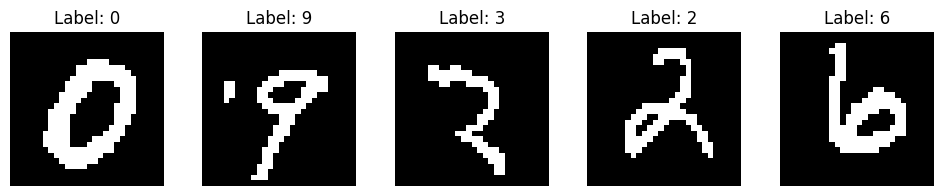

In [7]:
# Function to display a grid of images
def show_images(images, labels, title="MNIST Images"):
    images = images.numpy()  # Convert torch tensor to NumPy array
    fig, axes = plt.subplots(1, len(images), figsize=(12, 2))
    for i, ax in enumerate(axes):
        ax.imshow(np.squeeze(images[i]), cmap='gray')
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')  # Hide axis
    plt.show()

# Get a batch of training data from the DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the first 5 images
show_images(images[:5], labels[:5])

## Utility Functions

### Train Loop

In [8]:
import torch
from tqdm import tqdm

def train(model, criterion, optimizer, train_loader, val_loader, epochs=10, device='cuda'):
    # Training and validation loop
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []  # List to store train accuracies
    
    for epoch in range(epochs):  # Train for specified epochs
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

        for batch in progress_bar:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            # Calculate the number of correct predictions
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=loss.item())  

        # Compute average training loss and accuracy
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch[0].to(device), batch[1].to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Get the predicted labels for validation
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Compute average validation loss and accuracy
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {avg_loss:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Accuracy: {val_accuracy:.2f}%")

    return train_losses,  val_losses, train_accuracies, val_accuracies


### Plots and Evaluation

In [9]:
# Plot training and validation loss curves

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [10]:
# Plot training and validation loss curves

def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Loss')
    plt.plot(val_accuracies, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()


In [12]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

In [13]:
def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get the predicted labels
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    # Compute average test loss and accuracy
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / len(test_dataset)

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

## Simple Feed Forward Neural Network

In [14]:
class MNISTChar(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), 
            nn.ReLU(), 
            nn.Linear(512, 512), 
            nn.ReLU(),
            nn.Linear(512,10), 
        )

    def forward(self, x):
        x  = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits 




In [30]:

model = MNISTChar().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)

In [31]:
model

MNISTChar(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

## Training Simple NN

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)
train_losses, val_losses,train_accuracies, val_accuracies = train(model, criterion, optimizer, train_loader, val_loader, epochs=10)


Epoch 1/10: 100%|██████████| 750/750 [00:04<00:00, 182.27batch/s, loss=0.113] 


Epoch [1/10], Train Loss: 0.2958, Train Accuracy: 91.33%, Validation Loss: 0.2178, Validation Accuracy: 93.71%


Epoch 2/10: 100%|██████████| 750/750 [00:04<00:00, 184.06batch/s, loss=0.0417] 


Epoch [2/10], Train Loss: 0.1786, Train Accuracy: 95.07%, Validation Loss: 0.2128, Validation Accuracy: 94.30%


Epoch 3/10: 100%|██████████| 750/750 [00:04<00:00, 181.41batch/s, loss=0.11]   


Epoch [3/10], Train Loss: 0.1419, Train Accuracy: 95.92%, Validation Loss: 0.1791, Validation Accuracy: 95.38%


Epoch 4/10: 100%|██████████| 750/750 [00:04<00:00, 172.79batch/s, loss=0.287]  


Epoch [4/10], Train Loss: 0.1233, Train Accuracy: 96.48%, Validation Loss: 0.2386, Validation Accuracy: 94.01%


Epoch 5/10: 100%|██████████| 750/750 [00:04<00:00, 175.88batch/s, loss=0.0743] 


Epoch [5/10], Train Loss: 0.1201, Train Accuracy: 96.65%, Validation Loss: 0.1585, Validation Accuracy: 96.15%


Epoch 6/10: 100%|██████████| 750/750 [00:04<00:00, 187.29batch/s, loss=0.00136]


Epoch [6/10], Train Loss: 0.1027, Train Accuracy: 97.16%, Validation Loss: 0.1757, Validation Accuracy: 95.88%


Epoch 7/10: 100%|██████████| 750/750 [00:03<00:00, 187.70batch/s, loss=0.121]   


Epoch [7/10], Train Loss: 0.0940, Train Accuracy: 97.36%, Validation Loss: 0.1849, Validation Accuracy: 95.67%


Epoch 8/10: 100%|██████████| 750/750 [00:04<00:00, 184.76batch/s, loss=0.102]   


Epoch [8/10], Train Loss: 0.0924, Train Accuracy: 97.39%, Validation Loss: 0.1647, Validation Accuracy: 95.76%


Epoch 9/10: 100%|██████████| 750/750 [00:04<00:00, 183.07batch/s, loss=0.0347]  


Epoch [9/10], Train Loss: 0.0953, Train Accuracy: 97.44%, Validation Loss: 0.2168, Validation Accuracy: 95.22%


Epoch 10/10: 100%|██████████| 750/750 [00:04<00:00, 185.66batch/s, loss=0.0436]  


Epoch [10/10], Train Loss: 0.0927, Train Accuracy: 97.55%, Validation Loss: 0.1787, Validation Accuracy: 95.68%


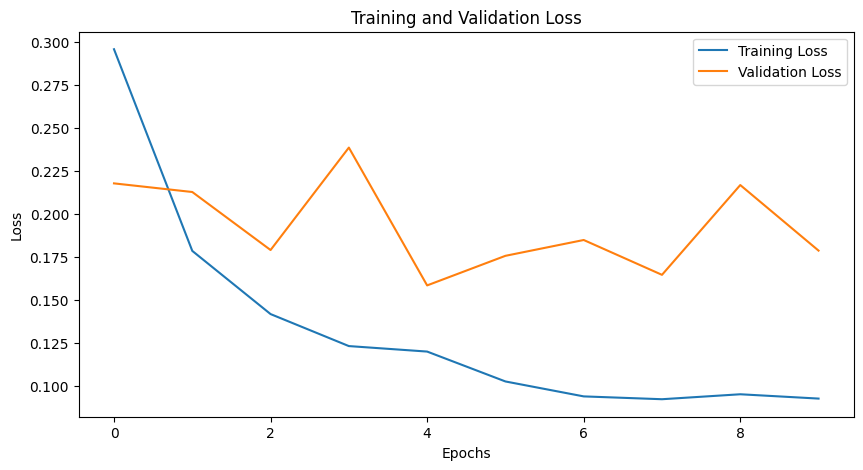

In [34]:
plot_losses(train_losses, val_losses)

## Model Evaluation - Feed Forward NN

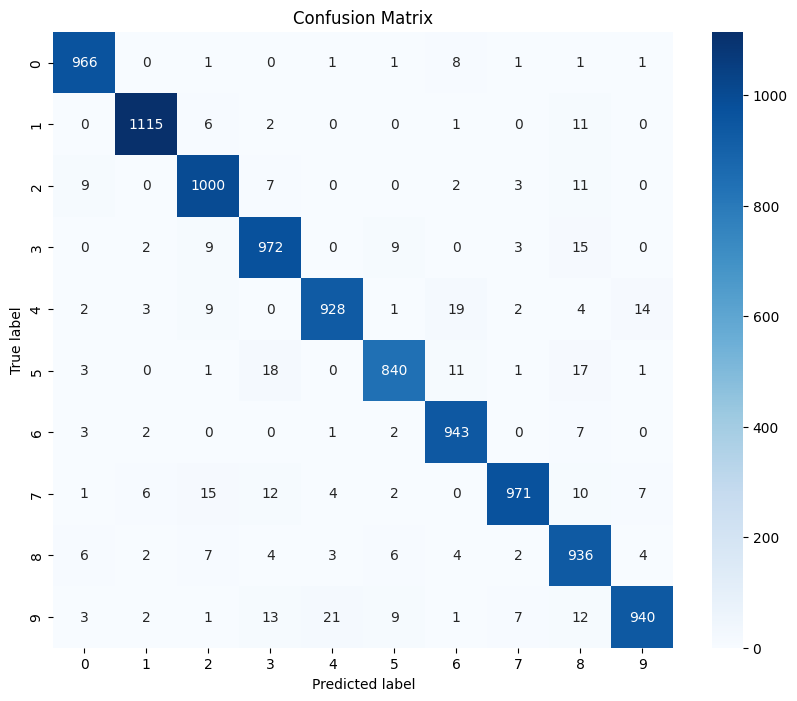

In [35]:
y_true, y_pred = evaluate_model(model, test_loader)
classes = [str(i) for i in range(10)]  # Class names for MNIST (0-9)
plot_confusion_matrix(y_true, y_pred, classes)

In [220]:

# Test the trained model
test(model, test_loader)

Test Loss: 0.1777, Test Accuracy: 0.9665


In [222]:
# Assuming `dataloader` is your DataLoader object
data_iter = iter(test_loader)

# Get the first batch of images and labels
images, labels = next(data_iter)

# Extract the first image and its label from the batch
single_image = images[0]
single_label = labels[0]
single_image = single_image.unsqueeze(0)
# Display the shape of the image
print("Image shape:", single_image.shape)
print("Label:", single_label)


Image shape: torch.Size([1, 1, 28, 28])
Label: tensor(7)


In [223]:
output = model(single_image.to(device))

In [224]:
output

tensor([[-47.3343,  -9.8796,  -9.7418,   4.3937,   2.1390, -21.4263, -84.1637,
          23.1598, -32.9354,   6.2891]], grad_fn=<AddmmBackward0>)

In [225]:
# Export the model to TorchScript
device = torch.device('cpu')
model.to(device)
example = torch.rand(1,1, 28, 28).to(device)
model.eval()  # Set the model to evaluation mode
scripted_model = torch.jit.trace(model,example)  # Use torch.jit.trace for tracing if needed
scripted_model.save('mnist_model.pt')  # Save the model

In [226]:
import pandas as pd
import numpy as np

# Read the data from the CSV file into a DataFrame
im1 = pd.read_csv('matrix.csv', header=None)  # Use header=None to prevent the first row from being interpreted as column names

# Convert the DataFrame to a NumPy array
im1 = im1.to_numpy().flatten()  # Flatten to ensure it's a 1D array

# Reshape the flattened array into a 28x28 matrix
if im1.size == 28 * 28:  # Ensure the data has the correct size
    im1 = im1.reshape(28, 28)  # Reshape into (1, 28, 28) format for further processing
else:
    print(f"Error: Expected 784 values, but found {im1.size}.")

In [227]:
im1.shape

(28, 28)

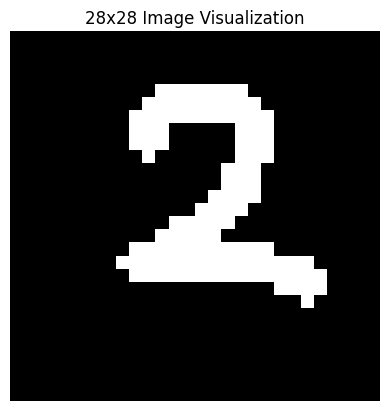

In [228]:
# Visualize the image using matplotlib
plt.imshow(im1, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.title('28x28 Image Visualization')
plt.axis('off')  # Hide axis ticks
plt.show()  # Display the image

## Convolutional NN

In [15]:
import torch.nn.functional as F 

In [16]:

class Conv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        """
        This function initializes the parameters for a conv2D layer

        Parameters
        ------------
        in_channels : int
        Number of channels in the input image

        out_channels : int
        Number of channels produced by the convolution

        kernel_size : int or tuple
        Size of the convolving kernel 

        stride : int or tuple
        Stride of the convolution. Default: 1

        padding: int, tuple or str
        Padding added to all four sides of the input. Default: 'same'
        """
        super(Conv2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = stride
        self.padding = padding

        self.weight = nn.Parameter(
            torch.nn.init.xavier_uniform_(
                torch.empty(
                    (self.out_channels, self.in_channels, *self.kernel_size),
                    requires_grad=True
                )
            )
        )
        self.bias = nn.Parameter(
            torch.zeros((self.out_channels,), requires_grad=True)
        )

    def forward(self, x):
        """
        This function performs convolution operation on the input
        Parameters
        ------------
        x : tensor, float32
        Input image to the convolution layer

        Returns
        ------------
        x : tensor, float32
        feature map output from the last layer
        """
        x = F.conv2d(x, self.weight, self.bias, stride=self.stride, padding=self.padding)
        x = F.relu(x)

        return x

In [17]:
class MaxPool2D(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        """
        This function initializes the parameters for a maxpool layer

        Parameters
        ------------
        kernel_size : int
        window height and width for the maxpooling window

        stride : int
        the stride of the window. Default value is kernel_size

        padding: int
        implicit zero padding to be added on both sides
        """
        super(MaxPool2D, self).__init__()
        self.kernel_size = kernel_size
        self.stride = kernel_size if stride is None else stride
        self.padding = padding


    def forward(self, x): 
        """
        This function performs max-pool operation on the input

        Parameters
        ------------
        x : tensor, float32
        Input image to the convolution layer

        Returns
        ------------
        x : tensor, float32
        max-pooled output from the last layer
        """
        x = F.max_pool2d(x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        return x

In [18]:
class Dense(nn.Module):
    def __init__(self, in_features, out_features, activation = None):
        """
        This function initializes the parameters for a dense layer
        Parameters
        ------------- 
        in_features : int
        shape of the input to the dense layer

        out_features : int
        number of units in the dense layer
        """
        super(Dense, self).__init__()
        self.in_features = in_features
        self.out_features =  out_features
        self.activation = activation
        
        self.weight = nn.Parameter(
            torch.nn.init.xavier_uniform_(
                torch.empty(
                    (self.in_features, self.out_features),
                    requires_grad=True,
                )
            )
        )
        self.bias = nn.Parameter(
            torch.zeros((self.out_features,), requires_grad=True)
        )

    def forward(self, x):
        """
        This function performs dense operation on the input
        Parameters
        ------------
        x : tensor, float32
        Input flattened image to the convolution layer

        Returns
        ------------
        x : tensor, float32
        linear operation output from the last layer
        """
        x = x @ self.weight + self.bias  # Supports batching
        if self.activation is not None:
            x = self.activation(x)
        return x



In [19]:
c1  = Conv2D(1, 16,3)
c2 = Conv2D(16, 32 , 3)
c3 = Conv2D(32, 64,3 )

pool = MaxPool2D(2, 2)

d1 = Dense(64 * 64 * 3 * 3, 128, activation=torch.nn.ReLU())
d2 = Dense(128, 10)

dropout = nn.Dropout(0.25)




x = torch.randn(64, 1,  28 , 28 )

x = F.relu(c1(x))
x = pool(x)
x = F.relu(c2(x))
x = pool(x)
x = F.relu(c3(x))
x = pool(x)

x = torch.flatten(x)
x = d1(x)
x = dropout(x)
x = d2(x)




In [20]:
x.shape

torch.Size([10])

In [21]:
x


tensor([-0.0836, -0.0433,  0.3380, -0.2233,  0.0618,  0.1903, -0.1230, -0.3264,
        -0.5059, -0.3723], grad_fn=<AddBackward0>)

In [22]:
print(type(x))

<class 'torch.Tensor'>


In [23]:
p = F.softmax(x)

/tmp/ipykernel_9797/4097683080.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p = F.softmax(x)


In [24]:
p

tensor([0.0994, 0.1035, 0.1516, 0.0865, 0.1150, 0.1308, 0.0956, 0.0780, 0.0652,
        0.0745], grad_fn=<SoftmaxBackward0>)

In [25]:
class MNISTCNN(nn.Module):
    def __init__(self):
        super(MNISTCNN, self).__init__()
        filter_dim = 3
        in_channels = [1, 16, 32]
        out_channels = [16, 32, 64]

        dense_in_features = [64 * 3 * 3, 128]
        dense_out_features = [128, 10]

        self.c1 = Conv2D(in_channels[0], out_channels[0], filter_dim)
        self.c2 = Conv2D(in_channels[1], out_channels[1], filter_dim)
        self.c3 = Conv2D(in_channels[2], out_channels[2], filter_dim)
        self.maxpool = MaxPool2D(2, 2)
        self.d1 = Dense(dense_in_features[0], dense_out_features[0], activation=torch.nn.ReLU())
        self.d2 = Dense(dense_in_features[1], dense_out_features[1], activation=torch.nn.ReLU())
        self.dropout = nn.Dropout(p= 0.25)


    def forward(self, x):

        x = F.relu(self.c1(x))
        x = self.maxpool(x)
        x = F.relu(self.c2(x))
        x = self.maxpool(x)
        x = F.relu(self.c3(x))
        x = self.maxpool(x)

        x = torch.flatten(x, start_dim=1)
        x = self.d1(x)
        x = self.dropout(x)
        x = self.d2(x)

        return x
        
        

In [26]:
model = MNISTCNN()
model.to(device)

MNISTCNN(
  (c1): Conv2D()
  (c2): Conv2D()
  (c3): Conv2D()
  (maxpool): MaxPool2D()
  (d1): Dense(
    (activation): ReLU()
  )
  (d2): Dense(
    (activation): ReLU()
  )
  (dropout): Dropout(p=0.25, inplace=False)
)

In [27]:
dummy_input = torch.zeros(64, 1, 28, 28).to(device)
dummy_output = model.forward(dummy_input)

In [28]:
dummy_output.shape

torch.Size([64, 10])

## Training CNN

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)
train_losses, val_losses,train_accuracies, val_accuracies = train(model, criterion, optimizer, train_loader, val_loader, epochs=15)


Epoch 1/15: 100%|██████████| 750/750 [00:04<00:00, 155.87batch/s, loss=0.697]


Epoch [1/15], Train Loss: 0.8401, Validation Loss: 0.5148, Train Accuracy: 68.45%, Validation Accuracy: 79.41%


Epoch 2/15: 100%|██████████| 750/750 [00:04<00:00, 158.20batch/s, loss=0.161] 


Epoch [2/15], Train Loss: 0.3180, Validation Loss: 0.1174, Train Accuracy: 89.41%, Validation Accuracy: 96.94%


Epoch 3/15: 100%|██████████| 750/750 [00:04<00:00, 155.54batch/s, loss=0.0741] 


Epoch [3/15], Train Loss: 0.1323, Validation Loss: 0.0837, Train Accuracy: 96.66%, Validation Accuracy: 97.88%


Epoch 4/15: 100%|██████████| 750/750 [00:04<00:00, 153.39batch/s, loss=0.0375] 


Epoch [4/15], Train Loss: 0.1048, Validation Loss: 0.0992, Train Accuracy: 97.32%, Validation Accuracy: 97.47%


Epoch 5/15: 100%|██████████| 750/750 [00:04<00:00, 156.90batch/s, loss=0.263]  


Epoch [5/15], Train Loss: 0.1127, Validation Loss: 0.0858, Train Accuracy: 97.07%, Validation Accuracy: 97.81%


Epoch 6/15: 100%|██████████| 750/750 [00:04<00:00, 158.41batch/s, loss=0.0568]  


Epoch [6/15], Train Loss: 0.1047, Validation Loss: 0.0883, Train Accuracy: 97.40%, Validation Accuracy: 97.63%


Epoch 7/15: 100%|██████████| 750/750 [00:04<00:00, 157.42batch/s, loss=0.00397] 


Epoch [7/15], Train Loss: 0.0985, Validation Loss: 0.1084, Train Accuracy: 97.41%, Validation Accuracy: 97.78%


Epoch 8/15: 100%|██████████| 750/750 [00:04<00:00, 155.57batch/s, loss=0.04]   


Epoch [8/15], Train Loss: 0.1083, Validation Loss: 0.0837, Train Accuracy: 97.18%, Validation Accuracy: 97.94%


Epoch 9/15: 100%|██████████| 750/750 [00:04<00:00, 155.43batch/s, loss=0.32]    


Epoch [9/15], Train Loss: 0.1008, Validation Loss: 0.1062, Train Accuracy: 97.42%, Validation Accuracy: 97.50%


Epoch 10/15: 100%|██████████| 750/750 [00:05<00:00, 148.24batch/s, loss=0.061]   


Epoch [10/15], Train Loss: 0.0936, Validation Loss: 0.0908, Train Accuracy: 97.57%, Validation Accuracy: 97.97%


Epoch 11/15: 100%|██████████| 750/750 [00:04<00:00, 156.72batch/s, loss=0.11]    


Epoch [11/15], Train Loss: 0.1021, Validation Loss: 0.1084, Train Accuracy: 97.47%, Validation Accuracy: 97.40%


Epoch 12/15: 100%|██████████| 750/750 [00:04<00:00, 155.67batch/s, loss=0.173]   


Epoch [12/15], Train Loss: 0.0956, Validation Loss: 0.1063, Train Accuracy: 97.55%, Validation Accuracy: 97.81%


Epoch 13/15: 100%|██████████| 750/750 [00:04<00:00, 158.51batch/s, loss=0.11]    


Epoch [13/15], Train Loss: 0.0916, Validation Loss: 0.0798, Train Accuracy: 97.69%, Validation Accuracy: 98.17%


Epoch 14/15: 100%|██████████| 750/750 [00:04<00:00, 156.21batch/s, loss=0.0625]  


Epoch [14/15], Train Loss: 0.0982, Validation Loss: 0.1191, Train Accuracy: 97.59%, Validation Accuracy: 97.27%


Epoch 15/15: 100%|██████████| 750/750 [00:04<00:00, 156.77batch/s, loss=0.000868]


Epoch [15/15], Train Loss: 0.0927, Validation Loss: 0.0971, Train Accuracy: 97.73%, Validation Accuracy: 97.92%


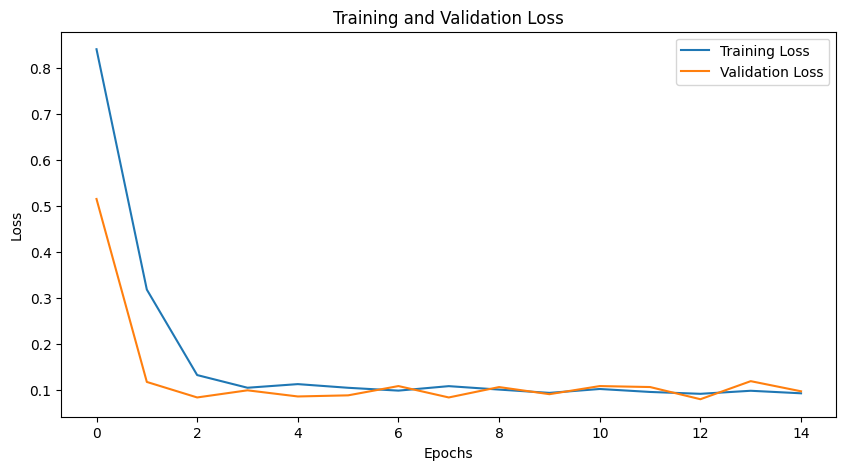

In [32]:
plot_losses(train_losses, val_losses)

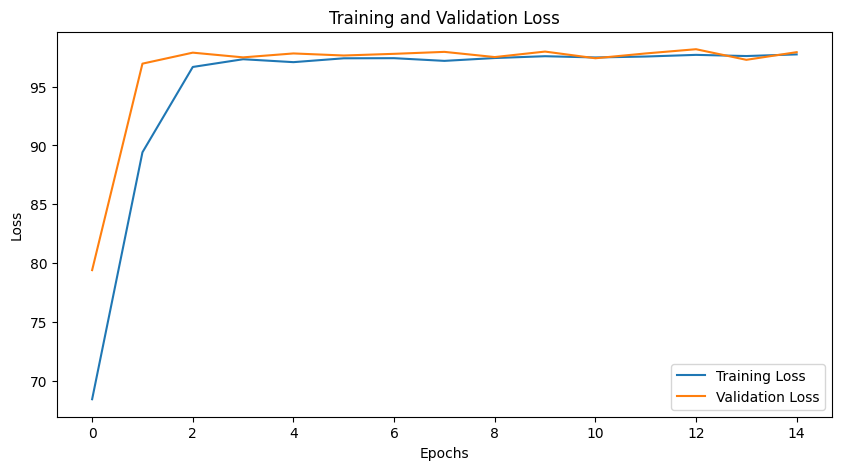

In [33]:
plot_accuracy(train_accuracies, val_accuracies)

## Model Evaluation - MINSTCNN

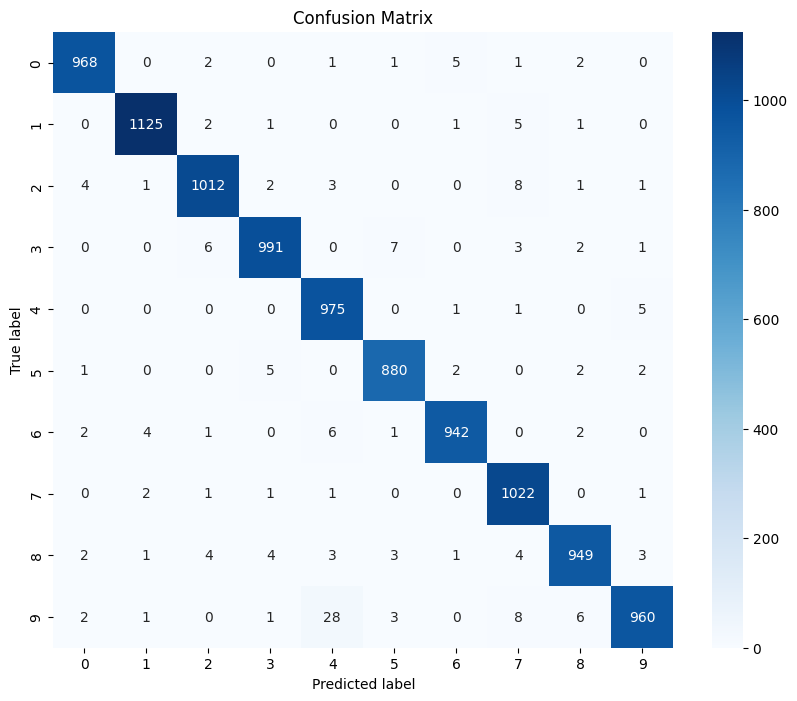

In [34]:
y_true, y_pred = evaluate_model(model, test_loader)
classes = [str(i) for i in range(10)]  # Class names for MNIST (0-9)
plot_confusion_matrix(y_true, y_pred, classes)

In [35]:
# Test the trained model
test(model, test_loader)

Test Loss: 0.0743, Test Accuracy: 0.9824


In [159]:
# Assuming `dataloader` is your DataLoader object
data_iter = iter(test_loader)

# Get the first batch of images and labels
images, labels = next(data_iter)

# Extract the first image and its label from the batch
single_image = images[0]
single_label = labels[0]
single_image = single_image.unsqueeze(0)
# Display the shape of the image
print("Image shape:", single_image.shape)
print("Label:", single_label)


Image shape: torch.Size([1, 1, 28, 28])
Label: tensor(7)


In [160]:
model.eval() 
with torch.no_grad():
    output = model(single_image.to(device)) 

In [161]:
output

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 25.4579,
          0.0000,  0.0000]], device='cuda:0')

In [36]:
# Export the model to TorchScript
device = torch.device('cpu')
model.to(device)
example = torch.rand(1, 1,28, 28).to(device)
model.eval()  # Set the model to evaluation mode
scripted_model = torch.jit.trace(model,example)  # Use torch.jit.trace for tracing if needed
scripted_model.save('mnist_CNN.pt')  # Save the model

In [37]:
torch.__version__

'2.4.1'